In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [7]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [8]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[1.4037],
         [0.0774]]),
 tensor([[1.0000e+00, 1.4037e+00, 9.8524e-01, 4.6100e-01, 1.6178e-01, 4.5420e-02,
          1.0626e-02, 2.1309e-03, 3.7390e-04, 5.8318e-05, 8.1863e-06, 1.0447e-06,
          1.2220e-07, 1.3195e-08, 1.3231e-09, 1.2382e-10, 1.0863e-11, 8.9697e-13,
          6.9950e-14, 5.1680e-15],
         [1.0000e+00, 7.7363e-02, 2.9926e-03, 7.7171e-05, 1.4926e-06, 2.3094e-08,
          2.9777e-10, 3.2909e-12, 3.1825e-14, 2.7356e-16, 2.1164e-18, 1.4885e-20,
          9.5961e-23, 5.7107e-25, 3.1557e-27, 1.6276e-29, 7.8696e-32, 3.5813e-34,
          1.5392e-36, 6.2674e-39]]),
 tensor([5.7604, 5.1932]))

实现一个函数来评估模型在给定数据集上的损失。

In [9]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [10]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.995496   1.1941627 -3.3694     5.6339216]]


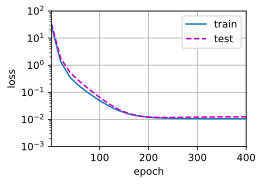

In [11]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.1500993 3.9301343]]


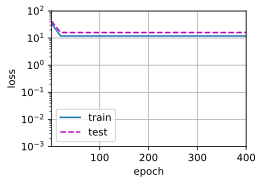

In [12]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.00028324e+00  1.25638640e+00 -3.40822387e+00  5.26445913e+00
   1.71017975e-01  1.18604732e+00  4.57615033e-02 -9.35181379e-02
  -1.95895582e-02  2.12320358e-01 -9.03806910e-02 -1.10593982e-01
   1.59263656e-01  8.24970193e-04 -1.02606967e-01 -1.23965696e-01
   3.56960893e-02 -1.09635890e-01  1.48537531e-01 -1.12481155e-02]]


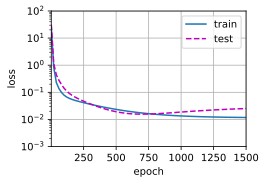

In [13]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)